Data cleaning: Dropped 0 invalid rows.
Feature selection: Dropped collinear features ['V1', 'V3', 'V5', 'V7', 'V12']
Running 5-fold CV (this may take a minute)...
CV Macro F1: 0.8221 (+/- 0.0244)

--- Test Set Evaluation ---
              precision    recall  f1-score   support

       Bumps       0.74      0.70      0.72        81
   Dirtiness       0.75      0.82      0.78        11
    K_Scatch       0.97      0.95      0.96        78
Other_Faults       0.77      0.79      0.78       135
      Pastry       0.59      0.69      0.64        32
      Stains       0.86      0.86      0.86        14
   Z_Scratch       0.97      0.92      0.95        38

    accuracy                           0.81       389
   macro avg       0.81      0.82      0.81       389
weighted avg       0.81      0.81      0.81       389



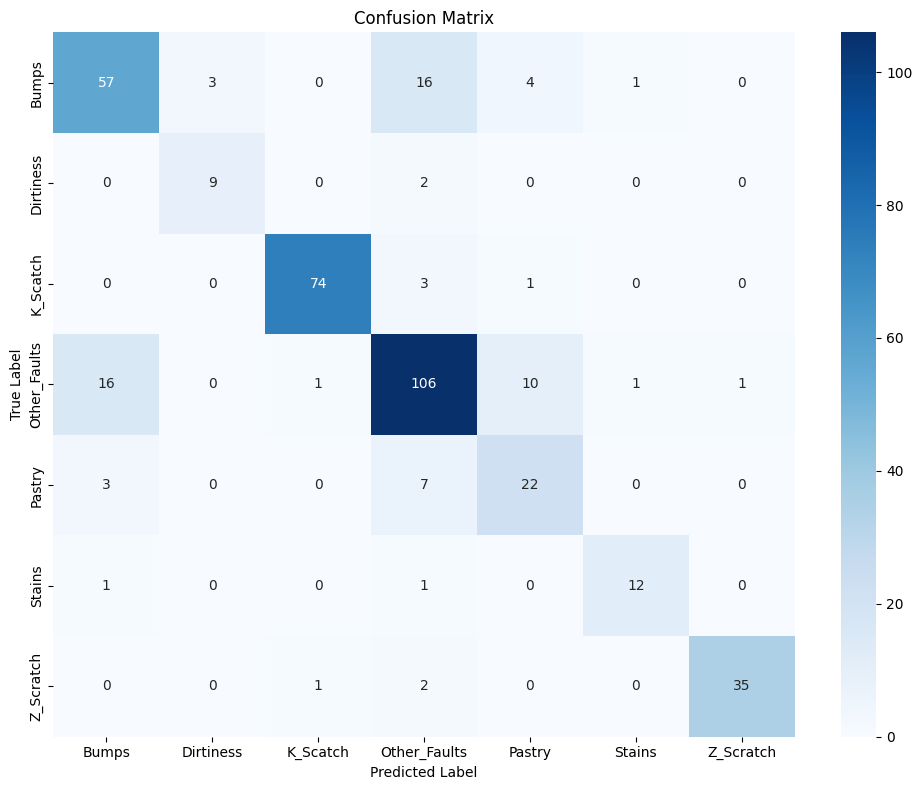

Saved CM to: outputs/confusion_matrix.png


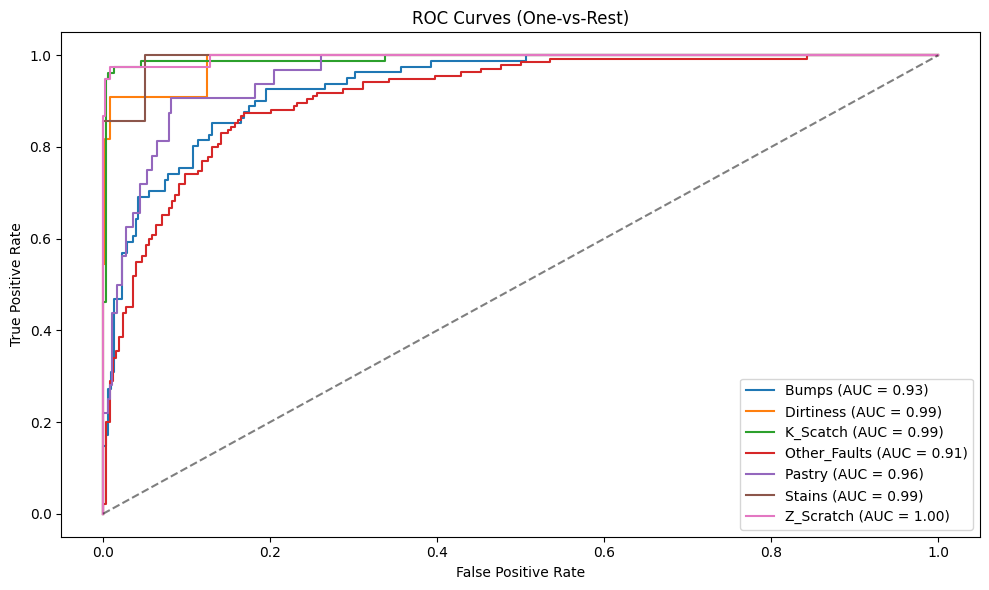

Saved ROC to: outputs/roc_curves.png
Model saved to: outputs/steel_fault_model.pkl


In [4]:

!pip install -q lightgbm

import os
import sys
import zipfile
import urllib.request
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, f1_score
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


%matplotlib inline

# Config
SEED = 42
DATA_URL = "https://archive.ics.uci.edu/static/public/198/steel+plates+faults.zip"
OUTPUT_DIR = Path("outputs")
CLASS_NAMES = [
    "Pastry", "Z_Scratch", "K_Scatch", "Stains",
    "Dirtiness", "Bumps", "Other_Faults"
]

def setup_env():
    """Create output dir if not exists."""
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def fetch_data() -> pd.DataFrame:
    """Download and extract dataset from UCI."""
    print(f"Downloading data from {DATA_URL}...")
    try:
        with urllib.request.urlopen(DATA_URL) as resp:
            with zipfile.ZipFile(BytesIO(resp.read())) as zf:
                target = next(n for n in zf.namelist() if "Faults.NNA" in n or "faults" in n.lower())
                with zf.open(target) as f:
                    df = pd.read_csv(f, sep=r'\s+', header=None)
                    return df
    except Exception as e:
        sys.exit(f"Error downloading data: {e}")

def preprocess_data(df: pd.DataFrame) -> tuple:
    """Clean data, remove collinear feats, split X/y."""
    feat_cols = [f"V{i}" for i in range(27)]
    df.columns = feat_cols + CLASS_NAMES

    # Filter invalid rows
    mask = df[CLASS_NAMES].sum(axis=1) == 1
    df_clean = df[mask].copy()
    print(f"Data cleaning: Dropped {len(df) - len(df_clean)} invalid rows.")

    X = df_clean[feat_cols]
    y_raw = df_clean[CLASS_NAMES].idxmax(axis=1)
    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # Remove Collinear Features
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X = X.drop(columns=to_drop)
    print(f"Feature selection: Dropped collinear features {to_drop}")

    return X, y, le, X.columns.tolist()

def train_model(X, y):
    """Train Voting Classifier."""
    lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.05, class_weight='balanced', random_state=SEED, verbose=-1)
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=SEED)
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')

    ensemble = VotingClassifier(
        estimators=[('lgbm', lgbm), ('rf', rf), ('lr', lr)],
        voting='soft',
        weights=[3, 2, 1],
        n_jobs=-1
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    print("Running 5-fold CV (this may take a minute)...")
    scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='f1_macro')
    print(f"CV Macro F1: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

    ensemble.fit(X_train, y_train)
    return ensemble, X_test, y_test

def evaluate_and_save(model, X_test, y_test, le):
    """Generate metrics, display and save plots."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    target_names = le.classes_

    print("\n--- Test Set Evaluation ---")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # --- Plot 1: Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save AND Show
    cm_path = OUTPUT_DIR / "confusion_matrix.png"
    plt.savefig(cm_path, dpi=300)
    plt.show()
    print(f"Saved CM to: {cm_path}")

    # --- Plot 2: ROC Curves ---
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(target_names):
        y_test_binary = (y_test == i).astype(int)
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, i])
        auc = roc_auc_score(y_test_binary, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Save AND Show
    roc_path = OUTPUT_DIR / "roc_curves.png"
    plt.savefig(roc_path, dpi=300)
    plt.show()
    print(f"Saved ROC to: {roc_path}")

    # Save Model
    model_path = OUTPUT_DIR / "steel_fault_model.pkl"
    joblib.dump(model, model_path)
    print(f"Model saved to: {model_path}")

# Run the pipeline
setup_env()
df_raw = fetch_data()
X, y, le, feats = preprocess_data(df_raw)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feats)
model, X_test, y_test = train_model(X_scaled, y)
evaluate_and_save(model, X_test, y_test, le)